In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

from battery_predictor_EIS import BatteryPredictor

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:
eis_curves = np.load('features.npy')
capacity = np.load('capacity.npy')

In [122]:
X = torch.tensor(eis_curves[:125]).to(device)
y = torch.tensor(capacity[:125]).to(device)
X = X.float()
y = y.float()
print(X.dtype, y.dtype)

print(X.shape, y.shape)

torch.float32 torch.float32
torch.Size([125, 20]) torch.Size([125])


In [41]:
y = y[0:X.shape[0]]
print(X.shape, y.shape)

torch.Size([275, 20]) torch.Size([275])


In [42]:
print(X.min(), X.max())
print(y.min(), y.max())

tensor(0.3463) tensor(0.6631)
tensor(14.7701) tensor(37.2108)


In [174]:
class BatteryDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.X_norm, self.y_norm = transform(X, y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X_norm[idx], self.y_norm[idx]

In [176]:
# 自定义归一化转换函数
class Normalize(object):
    def __call__(self, X, y):
        X_normalized = (X - X.min()) / (X.max() - X.min())
        y_normalized = (y - y.min()) / (y.max() - y.min())
        return X_normalized, y_normalized

In [44]:
def normalize_0_1(array):
    min_value = torch.min(array, axis=0)[0]
    max_value = torch.max(array, axis=0)[0]
    normalized_array = (array - min_value) / (max_value - min_value)
    return normalized_array

In [51]:
def normalize_zscore(array):
    mean = torch.mean(array, axis=0)
    std = torch.std(array, axis=0)
    normalized_array = (array - mean) / std
    return normalized_array

In [160]:
X_norm = normalize_0_1(X)
y_norm = normalize_0_1(y)

# X_norm = normalize_zscore(X)
# y_norm = normalize_zscore(y)


In [177]:
dataset = BatteryDataset(X, y, transform=Normalize())

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# print(train_size, val_size)

In [178]:
# 设置随机种子
def set_seed(seed):
    torch.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [179]:
set_seed(42)
predictor = BatteryPredictor(X.shape[1])
loss_list = []

In [180]:
from tqdm import tqdm

predictor.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4, weight_decay=0)
# optimizer = torch.optim.SGD(predictor.parameters(), lr=1e-4, momentum=0.8, weight_decay=1e-6)


for epoch in range(50):
    tqdm_dataloader = tqdm(train_dataloader, desc=f'Epoch: {epoch+1}')
    for batch_X, batch_y in tqdm_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X)
        
        loss = criterion(output, batch_y.unsqueeze(1))
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_dataloader.set_postfix(loss=loss.item())
        # print(batch_X)
        
        # print(output.data)
        # print(batch_y)
        # print('-' * 50)

Epoch: 50: 100%|██████████| 8/8 [00:00<00:00, 102.08it/s, loss=0.00111]


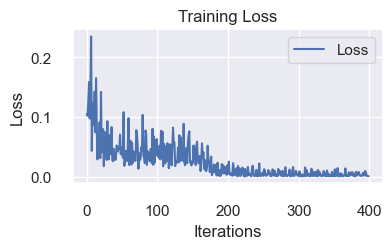

In [181]:
plt.figure(figsize=(4, 2))
plt.plot(loss_list, label="Loss")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [105]:
predictor.eval()

def plot_predictions_dataloader(predictor, dataloader, device):
    y, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = predictor(batch_X)
            y.extend(batch_y.cpu().numpy())
            y_pred.extend(output.cpu().numpy())
            
    # sorted_values = sorted(zip(y, y_pred), reverse=True)
    # y, y_pred = zip(*sorted_values)

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, len(y)+1)), y, label="True")
    plt.scatter(list(range(1, len(y_pred)+1)), y_pred, label="Predicted", color="orange", s=2)
    plt.title("Predictions")
    plt.xlabel("Number")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.show()

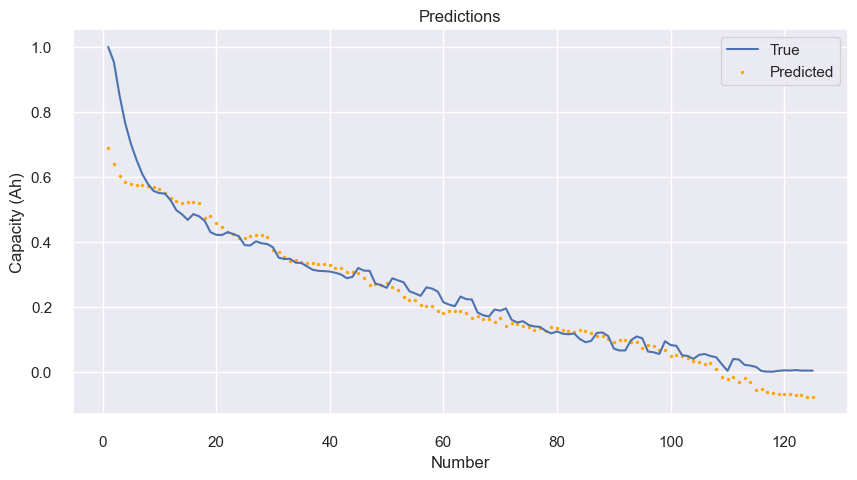

In [182]:
# plot_predictions_dataloader(predictor, train_dataloader, device)
# plot_predictions_dataloader(predictor, val_dataloader, device)

plot_predictions_dataloader(predictor, dataloader, device)

In [185]:
# Metrics
from sklearn.metrics import mean_squared_error, r2_score

def calculate_metrics(predictor, dataloader, device):
    y, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = predictor(batch_X)
            y.extend(batch_y.cpu().numpy())
            y_pred.extend(output.cpu().numpy())
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2

mse_train, r2_train = calculate_metrics(predictor, train_dataloader, device)

print(f"Train MSE: {mse_train:.4f}")
print(f"Train R2: {r2_train:.4f}")

Train MSE: 0.0036
Train R2: 0.9154
